In [56]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy
import math

import matplotlib.pyplot as plt
import seaborn as sns

import pint
from pint import UnitRegistry

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [52]:
from epftoolbox.evaluation import sMAPE

In [35]:
def to_CI(df):
    def celc(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degC)
        return home.to('degK')

    def ream(x):
        ureg = UnitRegistry()
        Q_ = ureg.Quantity
        home = Q_(x, ureg.degR)
        return home.to('degK')
    
    celc_features = ['ZT1AB', 'ZTNAC', 'ZTOIL', 'ZT1A', 'GEGTMC', 'ZTNAC_D']
    ream_features = ['ZTAMB']
    
    for cl in celc_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(celc(df[cl].values))
            
    for cl in ream_features:
        if cl in df.columns.to_list():
            df[cl] = pd.Series(ream(df[cl].values))
    
    return df

def preprocess_file(df, corr_ther, targets):
    def delete_corr(df, ther):
        was_corr = []
        corr = df.corr()
        for row in corr.iterrows():
            for v_ind in range(len(row[1])):
                if abs(row[1][v_ind]) > ther and abs(row[1][v_ind]) < 1: #ПЕРЕСЧИТАТЬ
                    if (row[0] not in was_corr) and (row[1].index[v_ind] not in was_corr):
                        was_corr.append(row[0])
        return was_corr
    #удалить лишние
    df = df.drop(['flight_datetime', 'engine_id'], axis = 1)
    
    #виды фичей
    to_categorical = ['IAIE','IBE','IBP','IAI','BRAT','engine_type','n1_modifier',
                         'IVS12','number_blades','engine_position','engine_family', 'manufacturer',
                         'aircraft_family','aircraft_type','aircraft_grp','ac_manufacturer']
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #убрать те у которых больше 2/3 пропущены значения
    for cl in numerical:
        if (cl in df.columns.to_list()) and (len(df[cl]) * 2 / 3 < df[cl].isna().sum()):
            df = df.drop([cl], axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    #заполнить оставшиеся пропуски нулями
    df = df.fillna(0)
    
    #перевести в систему СИ
    df = to_CI(df)

    #убрать скоррелированные фичи
    was_corr = delete_corr(df[numerical], corr_ther)
    df.drop(was_corr, axis = 1)
    #обновить список числовых фияей
    numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))
    
    #скалировать данные
    numerical_features_df = df[numerical]    
    #исправить типы данных категориальных фичей
    for cl in to_categorical:
        if cl in df.columns.to_list():
            df[cl] = df[cl].astype(str)
            #One Hot Encoding
            one_hot = pd.get_dummies(df[cl],prefix = cl)
            numerical_features_df = pd.concat([numerical_features_df, one_hot], axis=1)
    
    numerical_features_df = pd.concat([numerical_features_df, df[targets]], axis=1)
    return numerical_features_df

In [73]:
df = pd.read_csv("../data/grouped/cruise_CF34-8E.csv")       
targets = ['DEGT',
 'EGTC',
 'GPCN25',
 'GWFM',
 'PCN12',
 'PCN12I',
 'PCN1K',
 'PCN2C',
 'WBI',
 'WFMP',
 'ZPCN25_D',
 'ZT49_D',
 'ZTLA_D',
 'ZWF36_D']

to_categorical = ['IHPSOV','IBE','IBP','BRAT','WBI','number_blades','engine_position','engine_family',
                         'manufacturer', 'aircraft_family', 'aircraft_type','aircraft_grp', 'ac_manufacturer']

numerical = list(set(df.columns.to_list()) - set(to_categorical) - set(targets))

df = preprocess_file(df, 0.95, targets)
features = list(set(df.columns.to_list()) - set(targets))

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/pandas/core/construction.py:616: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


In [74]:
if 'WBI' in targets:
    targets.remove('WBI')
    
if 'BRAT' in targets:
    targets.remove('BRAT')

In [75]:
from lightgbm import LGBMRegressor

In [76]:
targets

['DEGT',
 'EGTC',
 'GPCN25',
 'GWFM',
 'PCN12',
 'PCN12I',
 'PCN1K',
 'PCN2C',
 'WFMP',
 'ZPCN25_D',
 'ZT49_D',
 'ZTLA_D',
 'ZWF36_D']

In [77]:
import json

In [78]:
X = df[features].values

metrics_dict = {
    'train rmse' : [0],
    'test rmse' : [0],
    'train r2_score' : [0],
    'test r2_score' : [0],
    'train smape' : [0],
    'test smape' : [0],
    'train mae' : [0],
    'test mae' : [0]
}

need_dict = {
    'EGTHDM' : [],
     'EGTHDM_D' : [],
     'PCN12' : [],
     'PCN1K' : [],
     'SLOATL' : [],
     'SLOATL_D' : [],
     'ZPCN25_D' : [],
     'ZT49_D' : [],
     'ZWF36_D' : []
}

for l in targets:
    y = df[l].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LGBMRegressor(learning_rate=0.5, n_estimators=20, max_depth=20)
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='rmse',
              early_stopping_rounds=1000)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics_dict['train rmse'] = [round(sqrt(mean_squared_error(y_train, y_train_pred)),3)]
    metrics_dict['test rmse'] = [round(sqrt(mean_squared_error(y_test, y_test_pred)),3)]
    
    metrics_dict['train r2_score'] = [round(r2_score(y_train, y_train_pred),3)]
    metrics_dict['test r2_score'] = [round(r2_score(y_test, y_test_pred),3)]
    
    metrics_dict['train smape'] = [round(sMAPE(y_train, y_train_pred),3)]
    metrics_dict['test smape'] = [round(sMAPE(y_test, y_test_pred),3)]
    
    metrics_dict['train mae'] = [round(mean_absolute_error(y_train, y_train_pred), 3)]
    metrics_dict['test mae'] = [round(mean_absolute_error(y_test, y_test_pred), 3)]
    
    metrics_dict = pd.DataFrame(metrics_dict)
    metrics_dict.to_csv(f'../data/takeoff_CF34-8E_{l}_metrics.csv', index = False)
    print(f'TARGET {l}')
    print(metrics_dict)
    
    model.booster_.save_model(f'../models/takeoff_CF34-8E_{l}.txt')
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    
    needeed = []
    for i in range(len(feature_importance[sorted_idx])):
        if feature_importance[sorted_idx][i] > 0:
            needeed.append(np.array(features)[sorted_idx][i])
    need_dict[l] = needeed

with open("../data/needed.json", "w") as outfile:
    json.dump(need_dict, outfile)

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'call

[1]	valid_0's rmse: 10.671	valid_0's l2: 113.871
[2]	valid_0's rmse: 9.48196	valid_0's l2: 89.9075
[3]	valid_0's rmse: 8.35168	valid_0's l2: 69.7506
[4]	valid_0's rmse: 7.41486	valid_0's l2: 54.9801
[5]	valid_0's rmse: 6.7785	valid_0's l2: 45.9481
[6]	valid_0's rmse: 6.32832	valid_0's l2: 40.0477
[7]	valid_0's rmse: 5.90401	valid_0's l2: 34.8573
[8]	valid_0's rmse: 5.60691	valid_0's l2: 31.4374
[9]	valid_0's rmse: 5.34187	valid_0's l2: 28.5356
[10]	valid_0's rmse: 5.13576	valid_0's l2: 26.376
[11]	valid_0's rmse: 4.99849	valid_0's l2: 24.9849
[12]	valid_0's rmse: 4.87508	valid_0's l2: 23.7665
[13]	valid_0's rmse: 4.76053	valid_0's l2: 22.6626
[14]	valid_0's rmse: 4.65608	valid_0's l2: 21.6791
[15]	valid_0's rmse: 4.53814	valid_0's l2: 20.5948
[16]	valid_0's rmse: 4.47656	valid_0's l2: 20.0396
[17]	valid_0's rmse: 4.41916	valid_0's l2: 19.529
[18]	valid_0's rmse: 4.32366	valid_0's l2: 18.694
[19]	valid_0's rmse: 4.27434	valid_0's l2: 18.27
[20]	valid_0's rmse: 4.21937	valid_0's l2: 17.8

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'call

[3]	valid_0's rmse: 1.58056	valid_0's l2: 2.49818
[4]	valid_0's rmse: 1.50348	valid_0's l2: 2.26046
[5]	valid_0's rmse: 1.43791	valid_0's l2: 2.06758
[6]	valid_0's rmse: 1.39413	valid_0's l2: 1.94359
[7]	valid_0's rmse: 1.33928	valid_0's l2: 1.79366
[8]	valid_0's rmse: 1.29357	valid_0's l2: 1.67333
[9]	valid_0's rmse: 1.26789	valid_0's l2: 1.60756
[10]	valid_0's rmse: 1.22734	valid_0's l2: 1.50636
[11]	valid_0's rmse: 1.20285	valid_0's l2: 1.44684
[12]	valid_0's rmse: 1.17905	valid_0's l2: 1.39017
[13]	valid_0's rmse: 1.16452	valid_0's l2: 1.3561
[14]	valid_0's rmse: 1.15134	valid_0's l2: 1.32557
[15]	valid_0's rmse: 1.14005	valid_0's l2: 1.29972
[16]	valid_0's rmse: 1.1217	valid_0's l2: 1.25821
[17]	valid_0's rmse: 1.11072	valid_0's l2: 1.23369
[18]	valid_0's rmse: 1.09929	valid_0's l2: 1.20845
[19]	valid_0's rmse: 1.08919	valid_0's l2: 1.18633
[20]	valid_0's rmse: 1.07828	valid_0's l2: 1.16269
TARGET GWFM
   train rmse  test rmse  train r2_score  test r2_score  train smape  \
0      

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's rmse: 1.56753	valid_0's l2: 2.45714
[2]	valid_0's rmse: 1.26373	valid_0's l2: 1.59701
[3]	valid_0's rmse: 1.25357	valid_0's l2: 1.57144
[4]	valid_0's rmse: 1.28418	valid_0's l2: 1.64911
[5]	valid_0's rmse: 1.20759	valid_0's l2: 1.45827
[6]	valid_0's rmse: 1.22016	valid_0's l2: 1.48879
[7]	valid_0's rmse: 1.23484	valid_0's l2: 1.52483
[8]	valid_0's rmse: 1.19835	valid_0's l2: 1.43604
[9]	valid_0's rmse: 1.17103	valid_0's l2: 1.3713
[10]	valid_0's rmse: 1.16118	valid_0's l2: 1.34834
[11]	valid_0's rmse: 1.17682	valid_0's l2: 1.3849
[12]	valid_0's rmse: 1.16836	valid_0's l2: 1.36506
[13]	valid_0's rmse: 1.1629	valid_0's l2: 1.35234
[14]	valid_0's rmse: 1.24703	valid_0's l2: 1.55508
[15]	valid_0's rmse: 1.28081	valid_0's l2: 1.64047
[16]	valid_0's rmse: 1.28249	valid_0's l2: 1.64477
[17]	valid_0's rmse: 1.3011	valid_0's l2: 1.69286
[18]	valid_0's rmse: 1.27799	valid_0's l2: 1.63326
[19]	valid_0's rmse: 1.29514	valid_0's l2: 1.67739
[20]	valid_0's rmse: 1.29039	valid_0's l2: 1

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'call

[3]	valid_0's rmse: 0.108605	valid_0's l2: 0.0117951
[4]	valid_0's rmse: 0.0988039	valid_0's l2: 0.0097622
[5]	valid_0's rmse: 0.0949066	valid_0's l2: 0.00900726
[6]	valid_0's rmse: 0.0907985	valid_0's l2: 0.00824437
[7]	valid_0's rmse: 0.087656	valid_0's l2: 0.00768357
[8]	valid_0's rmse: 0.0869441	valid_0's l2: 0.00755928
[9]	valid_0's rmse: 0.0861543	valid_0's l2: 0.00742256
[10]	valid_0's rmse: 0.0851747	valid_0's l2: 0.00725473
[11]	valid_0's rmse: 0.0843973	valid_0's l2: 0.00712291
[12]	valid_0's rmse: 0.083048	valid_0's l2: 0.00689697
[13]	valid_0's rmse: 0.0820675	valid_0's l2: 0.00673507
[14]	valid_0's rmse: 0.0813138	valid_0's l2: 0.00661193
[15]	valid_0's rmse: 0.0809447	valid_0's l2: 0.00655205
[16]	valid_0's rmse: 0.080357	valid_0's l2: 0.00645725
[17]	valid_0's rmse: 0.0804693	valid_0's l2: 0.00647531
[18]	valid_0's rmse: 0.0803035	valid_0's l2: 0.00644866
[19]	valid_0's rmse: 0.0803037	valid_0's l2: 0.00644868
[20]	valid_0's rmse: 0.0803352	valid_0's l2: 0.00645374
TARGE

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[7]	valid_0's rmse: 0.1011	valid_0's l2: 0.0102212
[8]	valid_0's rmse: 0.101267	valid_0's l2: 0.0102551
[9]	valid_0's rmse: 0.10118	valid_0's l2: 0.0102373
[10]	valid_0's rmse: 0.10111	valid_0's l2: 0.0102233
[11]	valid_0's rmse: 0.10146	valid_0's l2: 0.0102941
[12]	valid_0's rmse: 0.101612	valid_0's l2: 0.010325
[13]	valid_0's rmse: 0.101533	valid_0's l2: 0.0103089
[14]	valid_0's rmse: 0.101503	valid_0's l2: 0.0103028
[15]	valid_0's rmse: 0.102919	valid_0's l2: 0.0105923
[16]	valid_0's rmse: 0.103044	valid_0's l2: 0.0106181
[17]	valid_0's rmse: 0.103378	valid_0's l2: 0.010687
[18]	valid_0's rmse: 0.103514	valid_0's l2: 0.0107151
[19]	valid_0's rmse: 0.10343	valid_0's l2: 0.0106978
[20]	valid_0's rmse: 0.103275	valid_0's l2: 0.0106656
TARGET ZTLA_D
   train rmse  test rmse  train r2_score  test r2_score  train smape  \
0       0.074      0.101           0.284          0.094        1.547   

   test smape  train mae  test mae  
0       1.554      0.036     0.038  
[1]	valid_0's rmse: 19

In [58]:
model = LGBMRegressor(learning_rate=0.5, n_estimators=20, max_depth=20)
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='rmse',
          early_stopping_rounds=1000)

# Get predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print('train rmse', round(train_metric_rmse, 3))
print('test rmse', round(test_metric_rmse, 3))
print()

test_metric_r2_score = r2_score(y_test, y_test_pred)
train_metric_r2_score = r2_score(y_train, y_train_pred)
print('train r2_score', round(train_metric_r2_score, 3))
print('test r2_score', round(train_metric_r2_score, 3))
print()

print('train smape', round(sMAPE(y_train, y_train_pred), 3))
print('test smape', round(sMAPE(y_test, y_test_pred),3))
print()

print('train mape', round(mean_absolute_percentage_error(y_train, y_train_pred),3))
print('test mape', round(mean_absolute_percentage_error(y_test, y_test_pred), 3))
print()

print('train mae', round(mean_absolute_error(y_train, y_train_pred),3))
print('test mae', round(mean_absolute_error(y_test, y_test_pred), 3))

model.booster_.save_model('lgbr_base.txt')

[1]	valid_0's rmse: 4.23245	valid_0's l2: 17.9136
[2]	valid_0's rmse: 3.26949	valid_0's l2: 10.6896
[3]	valid_0's rmse: 2.66483	valid_0's l2: 7.10131
[4]	valid_0's rmse: 2.29457	valid_0's l2: 5.26504
[5]	valid_0's rmse: 2.04307	valid_0's l2: 4.17412
[6]	valid_0's rmse: 1.97242	valid_0's l2: 3.89043
[7]	valid_0's rmse: 1.86777	valid_0's l2: 3.48857
[8]	valid_0's rmse: 1.77611	valid_0's l2: 3.15458
[9]	valid_0's rmse: 1.72674	valid_0's l2: 2.98162
[10]	valid_0's rmse: 1.70813	valid_0's l2: 2.91772
[11]	valid_0's rmse: 1.6723	valid_0's l2: 2.7966
[12]	valid_0's rmse: 1.66539	valid_0's l2: 2.77351
[13]	valid_0's rmse: 1.62362	valid_0's l2: 2.63615
[14]	valid_0's rmse: 1.5907	valid_0's l2: 2.53033
[15]	valid_0's rmse: 1.58395	valid_0's l2: 2.5089
[16]	valid_0's rmse: 1.58108	valid_0's l2: 2.49982
[17]	valid_0's rmse: 1.58061	valid_0's l2: 2.49834
[18]	valid_0's rmse: 1.57543	valid_0's l2: 2.48197
[19]	valid_0's rmse: 1.5659	valid_0's l2: 2.45205
[20]	valid_0's rmse: 1.54677	valid_0's l2: 2.

/Users/tainella/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Text(0.5, 1.0, 'Feature Importance')

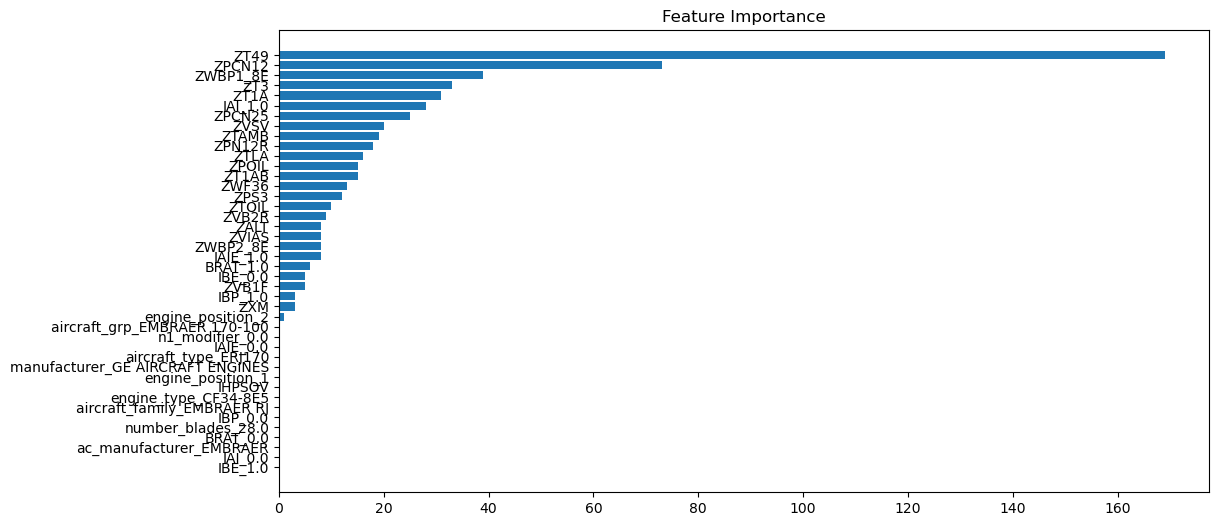

In [41]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Feature Importance')

In [42]:
needeed = []
for i in range(len(feature_importance[sorted_idx])):
    if feature_importance[sorted_idx][i] > 0:
        needeed.append(np.array(features)[sorted_idx][i])

In [43]:
needeed

['engine_position_2',
 'ZXM',
 'IBP_1.0',
 'ZVB1F',
 'IBE_0.0',
 'BRAT_1.0',
 'IAIE_1.0',
 'ZWBP2_8E',
 'ZVIAS',
 'ZALT',
 'ZVB2R',
 'ZTOIL',
 'ZPS3',
 'ZWF36',
 'ZT1AB',
 'ZPOIL',
 'ZTLA',
 'ZPN12R',
 'ZTAMB',
 'ZVSV',
 'ZPCN25',
 'IAI_1.0',
 'ZT1A',
 'ZT3',
 'ZWBP1_8E',
 'ZPCN12',
 'ZT49']

In [44]:
X = df[needeed].values
y = df['SLOATL'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
model = LGBMRegressor()
model.fit(X_train, y_train)
# Get predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_metric_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
train_metric_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
print('train rmse', round(train_metric_rmse, 3))
print('test rmse', round(test_metric_rmse, 3))

test_metric_r2_score = r2_score(y_test, y_test_pred)
train_metric_r2_score = r2_score(y_train, y_train_pred)
print('train r2_score', round(train_metric_r2_score, 3))
print('test r2_score', round(train_metric_r2_score, 3))

train rmse 1.142
test rmse 1.155
train r2_score 0.966
test r2_score 0.966
